In [1]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm
import numpy as np


current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')
# Enable latex in plot
# matplotlib.rcParams['text.usetex'] = True

run_dir = "../models"

In [2]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
0,pretrained_complete,linear_regression,Transformer,,-1,-1,20,12,8,fix_linear_regression_standard


In [3]:
task = "linear_regression"

run_id = "pretrained_complete"  # if you train more models, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

# Plot pre-computed metrics

In [4]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims


run_name: fix_linear_regression_standard, id: pretrained_complete


100%|██████████| 15/15 [00:00<00:00, 247695.12it/s]

------------------------


In [5]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [6]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size
data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

task = task_sampler()
metric = task.get_metric()

In [8]:
def R_Square_Error(ys, pred):
    y_mean = torch.mean(ys)

    SS_tot = torch.sum((ys - y_mean) ** 2)
    SS_res = torch.sum((ys - pred) ** 2)

    R_square = 1 - SS_res / SS_tot
    return R_square

### Setup - saving xs and ys lists

In [9]:
# n_batches = 100 
n_batches = 1 # We use n_batches = 1 here to speed up the experiment speed. We used n_batches = 100 for the experiment result in the paper
prompt_length = 76
# # save xs and ys for later parts
xs_list = [] 
ys_list = [] 
actual_points_w_1 = [[] for _ in range(prompt_length)]
predicted_points_w_1 = [[] for _ in range(prompt_length)]
i = 0
# Generate data and perform the experiment
for _ in tqdm(range(n_batches)):
    i += 1
    # if i%20 == 0:
    #     print(f"batch: {i}")
    xs = data_sampler.sample_xs(b_size=batch_size, n_points=prompt_length)
    # 64 x 101 x 20
    xs_list.append(xs)
    ys = task.evaluate(xs)
    # 64 x 101
    ys_list.append(ys)

    with torch.no_grad():
        pred = model(xs, ys)
    for j in range(prompt_length):
        actual_points_w_1[j].extend(ys[:, j])
        predicted_points_w_1[j].extend(pred[:, j])

  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
w_1 = []

for point_idx in range(prompt_length):
    actual = torch.tensor(actual_points_w_1[point_idx])
    predicted = torch.tensor(predicted_points_w_1[point_idx])
    R_square = R_Square_Error(actual, predicted)
    w_1.append(R_square)
    
torch.save(xs_list, './data/xs_list.pth')
torch.save(ys_list, './data/ys_list.pth')
with open('./data/exp_2_w_1.txt', 'w') as f:
    for value in w_1:
        f.write(f"{value}\n")


### Part 1 - random 10p

In [11]:
actual_points_10_random = [[] for _ in range(prompt_length)]
predicted_points_10_random = [[] for _ in range(prompt_length)]
xs_list = torch.load('./data/xs_list.pth')
ys_list = torch.load('./data/ys_list.pth')
# Generate data and perform the experiment
i = 0
print("start running")
for batch_idx in tqdm(range(n_batches)):
    print(batch_idx)
    i += 1
    # if i%10 == 0:
    #     print(f"batch: {i}")
    xs = xs_list[batch_idx]
    ys = ys_list[batch_idx]

    # j's idx starts at 1, but in graph, we refer it to 0
    pred = model(xs, ys)
    actual_points_10_random[0].extend(ys[:, 0])
    predicted_points_10_random[0].extend(pred[:, 0])
    
    for j in range(1, prompt_length):
        permuted_ys = np.copy(ys)
        if j > 2:  # if j == 1, 2, there are no prior labels or no need to permuted
            for i in range(batch_size):
                num_elements_to_shuffle = int(j * 0.10)
                indices_to_shuffle = np.random.choice(j, num_elements_to_shuffle, replace=False)
                elements_to_shuffle = permuted_ys[i, indices_to_shuffle]
                np.random.shuffle(elements_to_shuffle)
                permuted_ys[i, indices_to_shuffle] = elements_to_shuffle
            # print('sample', num_elements_to_shuffle)
                
        # Transfer np array to tensor
        permuted_ys_tensor = torch.from_numpy(permuted_ys)
        # predict with the si
        with torch.no_grad():
            pred = model(xs, permuted_ys_tensor)
        
        # for j in range(prompt_length):
        actual_points_10_random[j].extend(ys[:, j])
        predicted_points_10_random[j].extend(pred[:, j])

    random_10p = []

    for point_idx in range(prompt_length):
        actual = torch.tensor(actual_points_10_random[point_idx])
        predicted = torch.tensor(predicted_points_10_random[point_idx])
        R_square = R_Square_Error(actual, predicted)
        random_10p.append(R_square)

    with open('./data/exp_2_10p_random.txt', 'w') as f:
        for value in random_10p:
            f.write(f"{value}\n")
    print(f"Batch {batch_idx}: Finished exp_2_10p_random")

start running


  0%|          | 0/1 [00:00<?, ?it/s]

0
Batch 0: Finished exp_2_10p_random


### Part 2 - random 20p

In [12]:
actual_points_20_random = [[] for _ in range(prompt_length)]
predicted_points_20_random = [[] for _ in range(prompt_length)]
xs_list = torch.load('./data/xs_list.pth')
ys_list = torch.load('./data/ys_list.pth')
# Generate data and perform the experiment
i = 0
for batch_idx in tqdm(range(n_batches)):
    print(batch_idx)
    i += 1
    # if i%10 == 0:
    #     print(f"batch: {i}")
    xs = xs_list[batch_idx]
    ys = ys_list[batch_idx]

    # j's idx starts at 1, but in graph, we refer it to 0
    pred = model(xs, ys)
    actual_points_20_random[0].extend(ys[:, 0])
    predicted_points_20_random[0].extend(pred[:, 0])
    
    for j in range(1, prompt_length):
        permuted_ys = np.copy(ys)
        if j > 2:  # if j == 1, 2, there are no prior labels or no need to permuted
            for i in range(batch_size):
                num_elements_to_shuffle = int(j * 0.20)
                indices_to_shuffle = np.random.choice(j, num_elements_to_shuffle, replace=False)
                elements_to_shuffle = permuted_ys[i, indices_to_shuffle]
                np.random.shuffle(elements_to_shuffle)
                permuted_ys[i, indices_to_shuffle] = elements_to_shuffle
            # print('sample', num_elements_to_shuffle)
                
        # Transfer np array to tensor
        permuted_ys_tensor = torch.from_numpy(permuted_ys)
        # predict with the si
        with torch.no_grad():
            pred = model(xs, permuted_ys_tensor)
        
        # for j in range(prompt_length):
        actual_points_20_random[j].extend(ys[:, j])
        predicted_points_20_random[j].extend(pred[:, j])

    random_20p = []

    for point_idx in range(prompt_length):
        actual = torch.tensor(actual_points_20_random[point_idx])
        predicted = torch.tensor(predicted_points_20_random[point_idx])
        R_square = R_Square_Error(actual, predicted)
        random_20p.append(R_square)

    with open('./data/exp_2_20p_random.txt', 'w') as f:
        for value in random_20p:
            f.write(f"{value}\n")
    print(f"Batch {batch_idx}: Finished exp_2_20p_random")

  0%|          | 0/1 [00:00<?, ?it/s]

0
Batch 0: Finished exp_2_20p_random


In [13]:
with open('./data/base_line.txt', 'r') as file:
    base_line = [float(line.strip()) for line in file]

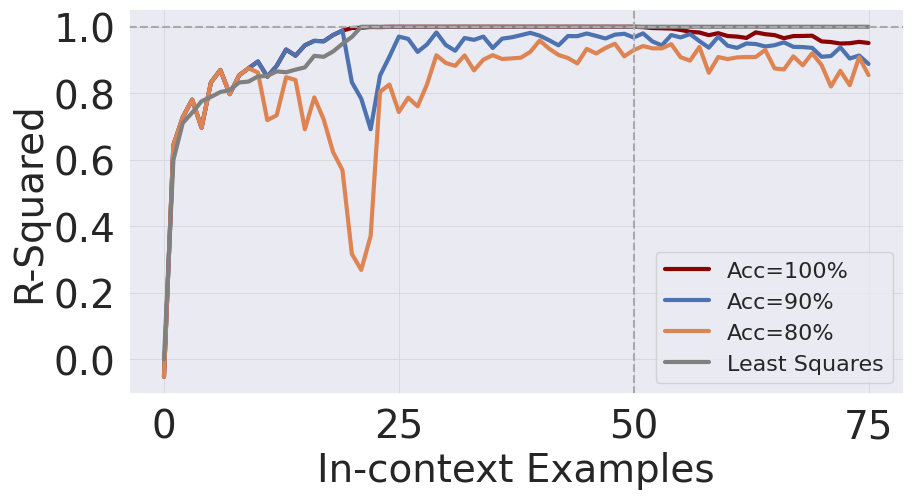

In [15]:

plt.figure(figsize=(10, 5), facecolor='none')
plt.plot(range(prompt_length), w_1, label="Acc=100%", linewidth=3, color="darkred")
plt.plot(range(prompt_length), random_10p, label="Acc=90%", linewidth=3)
plt.plot(range(prompt_length), random_20p, label="Acc=80%", linewidth=3)
plt.plot(range(prompt_length), base_line, label="Least Squares", linewidth=3, color="grey")
x = [0, 25, 50, 75]
plt.xticks(x, fontsize=28)
plt.yticks(fontsize=28)
plt.axhline(1, ls="--", color="darkgrey")
plt.axvline(x=50, color='darkgrey', linestyle='--')  # Grey vertical line
plt.legend(loc='lower right', fontsize=16)
plt.xlabel('In-context Examples', fontsize=28)
plt.ylabel('R-Squared', fontsize=28)
plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
# save figs
plt.savefig("../output/4_2.pdf", bbox_inches = "tight", transparent=True)
plt.show()